## Dependencies

In [ ]:
import inflection
import optuna
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from matplotlib import rcParams
from optuna.samplers import TPESampler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import FunctionTransformer
from feature_engine.encoding import OneHotEncoder
from imblearn.pipeline import make_pipeline as imblearn_pipeline
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

# if there is a warning to be suppresed
import warnings
warnings.filterwarnings("ignore")

# matplotlib settings
rcParams['figure.figsize'] = (21, 8)
rcParams['lines.linewidth'] = 3
rcParams['xtick.labelsize'] = 'x-large'
rcParams['ytick.labelsize'] = 'x-large'
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['axes.spines.bottom'] = True
rcParams['axes.spines.left'] = True
COLORS = ['#99d594', '#D53E4F', '#FC8D59']

# for reproducibility
SEED = 0

# f0.5: more weight on precision, less weight on recall.
fhalf_scorer = make_scorer(fbeta_score, beta=0.5) # | recently added.

def load_dataset(path):
    df = pd.read_csv(path)
    df.columns = [inflection.underscore(var) for var in list(df.columns)]    
    return df

def data_preparation(df):
    df = df.copy()
    
    # drop duplicated data
    df = df.drop_duplicates()
    
    # parsing to string
    variables = ['operating_systems', 'browser', 'region', 'traffic_type']
    df[variables] = df[variables].astype(str)
    
    # parsing month to integer # | recently revised. parsing to quarter
    df['month'] = df['month'].map({
        'Jan': 'Q1', 
        'Feb': 'Q1', 'Mar': 'Q1', 
        'Apr': 'Q2', 
        'May': 'Q2', 'June': 'Q2', 
        'Jul': 'Q3', 'Aug': 'Q3', 'Sep': 'Q3', 
        'Oct': 'Q4', 'Nov': 'Q4', 'Dec': 'Q4'
    })
    
    # parsing weekend and revenue to integer 
    variables = ['weekend', 'revenue'] # | recently added
    df[variables] = df[variables].astype(int)

    # add new features
    df['avg_adm_duration_per_page'] = (df['administrative_duration'] / df['administrative']).fillna(0)
    df['avg_inf_duration_per_page'] = (df['informational_duration'] / df['informational']).fillna(0)
    df['avg_prod_duration_per_page'] = (df['product_related_duration'] / df['product_related']).fillna(0)
    
    return df

def split_dataset(df, target='revenue', test_size=0.2, seed=0):
    return train_test_split(
        df,
        test_size=test_size,
        random_state=seed,
        stratify=df[target]
    )

## 0. Notes

Sebelum melakukan eksperimen, data preprocessing dibagi menjadi dua yaitu
* Data preprocessing untuk model linear: feature transformation, feature scaling, feature encoding, dan resampling
* Data preprocessing untuk model tree-based: feature encoding dan resampling

Feature yang tidak digunakan untuk modelling sebagai berikut. Alasan tidak digunakan karena feature-feature tersebut 
sudah diencode dan tidak ada informasi mengenai kategori setiap angka. Tanpa informasi tersebut akan sulit untuk mengintepretasikan feature tersebut setelah modelling.
* `operating_systems`
* `browser`
* `region`
* `traffic_type`

Untuk masing-masing tahap data preprocessing, akan digunakan konfigurasi seperti dibawah ini. Namun, tidak menutup kemungkinan untuk mengubahnya jika dirasa perlu.
* Feature transformation: **log-transformer (np.log1p)**
* Feature scaling: **RobustScaler**
* Feature encoding ditentukan berdasarkan karakteristik feature.
    * `visitor_type`, `month`: **OneHotEncoder**
* Resampling: **SMOTE**

In [ ]:
# data preparation
df = load_dataset('online_shoppers_intention.csv')
df = data_preparation(df)
df = df.drop(['operating_systems', 'browser', 'region', 'traffic_type'], axis=1)

In [ ]:
def preprocessed_data(train, test, numerical, categorical, is_linear=True):
    # split into features and label
    target = 'revenue'
    X_train = full_train.drop(target, axis=1)
    y_train = full_train[target]
    X_test = test.drop(target, axis=1)
    y_test = test[target]
    
    # transformation + scaling
    if is_linear:
        log_trf = make_pipeline(
            FunctionTransformer(np.log1p), 
            RobustScaler()
        )
        X_train.loc[:, numerical] = log_trf.fit_transform(X_train[numerical])
        X_test.loc[:, numerical] = log_trf.transform(X_test[numerical])
    
    # label encoding
    one_hot_enc = OneHotEncoder(variables=categorical)
    X_train = one_hot_enc.fit_transform(X_train)
    X_test = one_hot_enc.transform(X_test)
    
    return X_train, X_test, y_train, y_test

## 1. Modeling

### A. Split data train dan test


Sebelum data preprocessing dan modelling, data di-split menjadi dua yaitu train set dan test set agar tidak terjadi data leakage. Rasio split yang digunakan 80% train set dan 20% test set. Kemudian agar distribusi target antara train dan test set tetap sama maka menggunakan stratified sampling.

In [ ]:
# set up the validation framework
target = 'revenue'
full_train, test = split_dataset(df, target=target, test_size=0.2)

In [ ]:
full_train[target].value_counts(normalize=True).round(2)

0    0.84
1    0.16
Name: revenue, dtype: float64

In [ ]:
test[target].value_counts(normalize=True).round(2)

0    0.84
1    0.16
Name: revenue, dtype: float64

### B. Model yang digunakan

Model klasifikasi yang digunakan sebagai berikut. Hampir seluruh model merupakan tree-based model. Alasan memilih tree-based model karena tepat digunakan untuk karakteristik dataset yang memiliki distribusi right-skewed dan terdapat banyak outliers.

* Logistic Regression (baseline model)
* Decision Tree
* Random Forest
* Extra Trees
* Ada Boost
* XGBoost

In [ ]:
def classifier(seed=SEED):
    clfs = {}
    clfs['LogisticRegression'] = LogisticRegression(
        random_state=seed,
        C=0.01,
        solver='lbfgs',
        class_weight='balanced',
        max_iter=5000
    )
    clfs['DecisionTreeClassifier'] = DecisionTreeClassifier(
        random_state=seed,
        max_depth=7,
        class_weight='balanced',
    )
    clfs['RandomForestClassifier'] = RandomForestClassifier(
        random_state=seed,
        max_depth=7,
        class_weight="balanced_subsample"
    )
    clfs['ExtraTreesClassifier'] = ExtraTreesClassifier(
        random_state=seed,
        max_depth=7,
        class_weight="balanced_subsample"
    )
    clfs['AdaBoostClassifier'] = AdaBoostClassifier(
        random_state=seed,
    )
    clfs['XGBClassifier'] = XGBClassifier(
        random_state=seed,
        n_jobs=-1,
        max_depth=7,
        scale_pos_weight=2
    )
    return clfs

### C. Model evaluation: Pemilihan metrics

Evaluation metrics yang digunakan adalah precision dan ROC-AUC score.

Alasan memilih precision karena kesalahan prediksi seorang visitor membeli padahal aktualnya tidak membeli (false positive) lebih beresiko mengurangi revenue dibandingkan kesalahan prediksi seorang visitor tidak membeli namun aktualnya membeli (false negative).

Alasan memilih ROC-AUC score yaitu sebagai metric tambahan untuk mengevaluasi performa model pada dataset yang imbalance.

In [ ]:
def model_evaluation(model, X, y, dataset='Train', use_pipeline=True):
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1]
    
    if use_pipeline:
        model_name = list(model.named_steps.keys())[-1]
    else:
        model_name = str(model)
    
    return {
        'model': model_name,
        f"Accuracy ({dataset} set)": round(accuracy_score(y, y_pred), 3), 
        f"Precision ({dataset} set)": round(precision_score(y, y_pred), 3),
        f"Recall ({dataset} set)": round(recall_score(y, y_pred), 3),
        f"F1 ({dataset} set)": round(f1_score(y, y_pred), 3),
        f"F0.5 ({dataset} set)": round(fbeta_score(y, y_pred, beta=0.5), 3),
        f"ROC AUC ({dataset} set)": round(roc_auc_score(y, y_proba), 3),
    }

### D. Model evaluation: Hasil modelling

In [ ]:
def train_the_model(clf, numerical, categorical, is_linear=True):
    # preprocessed data
    X_train, X_test, y_train, y_test = preprocessed_data(full_train, test, numerical, categorical, is_linear=is_linear)
    
    # pipeline for the resampler and classifier
    model = imblearn_pipeline(
        SMOTE(sampling_strategy='all', random_state=0), 
        clf
    )
    model.fit(X_train, y_train)
    return (
        model_evaluation(model, X_train, y_train, dataset='Train'),
        model_evaluation(model, X_test, y_test, dataset='Test')
    )

In [ ]:
def evaluate_metrics(numerical, categorical, clf_dict):        
    train_results = []
    test_results = []
    
    for i, model_name in enumerate(clf_dict.keys()):
        if model_name == 'LogisticRegression':
            result = train_the_model(clf_dict[model_name], numerical, categorical, is_linear=True)
        else:
            result = train_the_model(clf_dict[model_name], numerical, categorical, is_linear=False)
        
        train_results.append(pd.DataFrame([result[0]]))
        test_results.append(pd.DataFrame([result[1]]))
        
    print("Train set evaluation")
    display(pd.concat(train_results).reset_index(drop=True))
    print("\nTest set evaluation")
    display(pd.concat(test_results).reset_index(drop=True))

numerical = [
    'administrative', 'administrative_duration', 'informational',
    'informational_duration', 'product_related', 'product_related_duration',
    'bounce_rates', 'exit_rates', 'page_values', 'special_day', 
    'avg_adm_duration_per_page', 'avg_inf_duration_per_page', 'avg_prod_duration_per_page'
]
categorical = ['visitor_type', 'month']
clf_dict = classifier()
before_tuning = evaluate_metrics(numerical, categorical, clf_dict)
before_tuning

Train set evaluation


,model,Accuracy (Train set),Precision (Train set),Recall (Train set),F1 (Train set),F0.5 (Train set),ROC AUC (Train set)
0,logisticregression,0.878,0.583,0.777,0.666,0.614,0.912
1,decisiontreeclassifier,0.900,0.652,0.770,0.706,0.673,0.932
2,randomforestclassifier,0.896,0.632,0.799,0.706,0.660,0.936
3,extratreesclassifier,0.765,0.347,0.569,0.431,0.377,0.819
4,adaboostclassifier,0.883,0.610,0.697,0.651,0.626,0.909
5,xgbclassifier,0.938,0.750,0.901,0.818,0.776,0.983



Test set evaluation


,model,Accuracy (Test set),Precision (Test set),Recall (Test set),F1 (Test set),F0.5 (Test set),ROC AUC (Test set)
0,logisticregression,0.887,0.606,0.791,0.686,0.636,0.910
1,decisiontreeclassifier,0.889,0.629,0.704,0.664,0.642,0.901
2,randomforestclassifier,0.890,0.618,0.780,0.690,0.645,0.922
3,extratreesclassifier,0.769,0.347,0.542,0.423,0.374,0.806
4,adaboostclassifier,0.889,0.629,0.709,0.667,0.643,0.905
5,xgbclassifier,0.881,0.598,0.733,0.659,0.621,0.920


**Pengamatan**

* Logistic Regression cenderung sudah best fit yang mana nilai ROC AUC score pada train dan test set hampir sama sebesar 0.910 dan 0.912.
* Tree-based model seperti Random Forest, Extra Trees, dan Ada Boost, cenderung tidak overfitting. Namun Decision Tree dan XGBoost masih overfitting.
* Tree-based model yang paling bagus adalah Random Forest dengan ROC AUC dan precision test sebesar 0.922 dan 0.618.

## Cross validation & Hyperparameter tuning

#### Cross validation setup

Cross validation menggunakan 5 fold dan stratified sampling untuk membentuk masing-masing fold agar distribusi target setiap fold tetap sama.

#### Hyperparameter tuning setup

Hanya tree-based model saja yang di-tuning karena di awal menganggap Logistic Regression sebagai baseline model untuk mengukur seberapa bagus performa tree-based model jika dibandingkan dengan Logistic Regression. 

#### Hasil hyperparameter tuning

Hyperparameter tuning untuk berbagai tree-based model berada di notebook terpisah dan menggunakan Optuna agar proses tuning lebih singkat dibandingkan RandomizedSearchCV atau GridSearchCV. Berikut ini link untuk notebook tersebut.
* [exp-hyperparameter-tuning.ipynb](https://github.com/irfan-fadhlurrahman/online-shoppers-purchasing-intention/blob/main/stage-3/exp-hyperparameter-tuning.ipynb)

Parameter yang digunakan tree-based model cenderung sama. Parameter yang umum digunakan untuk di-tuning sebagai berikut.
* n_estimators: jumlah subtree yang akan dibangun. Semakin banyak subtree, semakin meningkatkan waktu komputasi

* criterion: cara menghitung impurity pada feature (gini, entropy). melihat feature mana yang menjadi root/node

* max_depth: maksimal kedalaman tree untuk mencegah overfitting

* min_sample_split: berapa jumlah sample yg dibutuhkan pada node untuk membuat leaf baru (agar tidak terlalu sedikit sehingga mengakibatkan overfit).

* min_sample_leaf: berapa jumlah sample yg dibutuhkan pada leaf agar leaf terbentuk (agar tidak terlalu sedikit sehingga mengakibatkan overfit).

In [ ]:
def best_trial_result(clf_name='DecisionTreeClassifier'):
    with open(f"{clf_name}_study.pkl", 'rb') as f_in:
        return joblib.load(f_in)
    
def guard():
    print("Best trial until now:")
    print(f"Classifier: {clf_name}")
    print(" Value (precision_test mean): ", study.best_trial.value)
    print(" Params: ")
    for key, value in study.best_trial.params.items():
        print(f"    {key}: {value}")
    print()
    #return study
    pass

classifier_name = [
    "DecisionTreeClassifier",
    "RandomForestClassifier",
    "ExtraTreesClassifier",
    "AdaBoostClassifier",
    "XGBClassifier",
]

def main():
    classifier_name = [
        "DecisionTreeClassifier",
        "RandomForestClassifier",
        "ExtraTreesClassifier",
        "AdaBoostClassifier",
        "XGBClassifier",
    ]
    classifier_obj = [
        DecisionTreeClassifier,
        RandomForestClassifier,
        ExtraTreesClassifier,
        AdaBoostClassifier,
        XGBClassifier,
    ]
    tuned_model = {}
    for name, obj in zip(classifier_name, classifier_obj):
        params = best_trial_result(clf_name=name).best_trial.params
        tuned_model[name] = obj(random_state=0, **params)
    
    return tuned_model
    
tuned_model = main()
tuned_model

{'DecisionTreeClassifier': DecisionTreeClassifier(max_depth=5, min_samples_leaf=46, min_samples_split=53,
                        random_state=0),
 'RandomForestClassifier': RandomForestClassifier(max_depth=40, min_samples_split=17, n_estimators=108,
                        random_state=0),
 'ExtraTreesClassifier': ExtraTreesClassifier(criterion='entropy', max_depth=34, min_samples_split=29,
                      n_estimators=349, random_state=0),
 'AdaBoostClassifier': AdaBoostClassifier(algorithm='SAMME', learning_rate=0.0051902630176951636,
                    n_estimators=224, random_state=0),
 'XGBClassifier': XGBClassifier(colsample_bytree=0.6, learning_rate=0.001005714700171731,
               max_depth=35, min_child_weight=13, n_estimators=337,
               reg_alpha=0.1, reg_lambda=0.00019766276396399466,
               scale_pos_weight=0.1, subsample=0.7)}

In [ ]:
numerical = [
    'administrative', 'administrative_duration', 'informational',
    'informational_duration', 'product_related', 'product_related_duration',
    'bounce_rates', 'exit_rates', 'page_values', 'special_day', 
    'avg_adm_duration_per_page', 'avg_inf_duration_per_page', 'avg_prod_duration_per_page'
]
categorical = ['visitor_type', 'month']
after_tuning = evaluate_metrics(numerical, categorical, tuned_model)
after_tuning

Train set evaluation


,model,Accuracy (Train set),Precision (Train set),Recall (Train set),F1 (Train set),F0.5 (Train set),ROC AUC (Train set)
0,decisiontreeclassifier,0.894,0.638,0.749,0.689,0.658,0.915
1,randomforestclassifier,0.940,0.790,0.837,0.813,0.799,0.984
2,extratreesclassifier,0.927,0.762,0.778,0.770,0.765,0.970
3,adaboostclassifier,0.870,0.559,0.805,0.660,0.596,0.879
4,xgbclassifier,0.857,0.971,0.088,0.161,0.322,0.923



Test set evaluation


,model,Accuracy (Test set),Precision (Test set),Recall (Test set),F1 (Test set),F0.5 (Test set),ROC AUC (Test set)
0,decisiontreeclassifier,0.892,0.637,0.720,0.676,0.652,0.908
1,randomforestclassifier,0.893,0.649,0.696,0.672,0.658,0.924
2,extratreesclassifier,0.885,0.633,0.636,0.634,0.633,0.910
3,adaboostclassifier,0.879,0.581,0.809,0.676,0.616,0.882
4,xgbclassifier,0.853,1.000,0.058,0.109,0.234,0.914


**Pengamatan**
* Setelah hyperparameter tuning, seluruh tree-based model hampir semuanya overfitted kecuali Decision Tree.
* Jika dibandingkan dengan sebelum tuning, performa model sebelum tuning lebih baik.

Oleh karena itu, akan menggunakan model sebelum tuning untuk mengevaluasi feature importance. Model yang dipilih adalah Random Forest karena dibandingkan dengan tree-based model lainnya memiliki nilai ROC-AUC test paling tinggi dan tidak overfitted.

## 2. Feature Importance

### A. Feature Importance

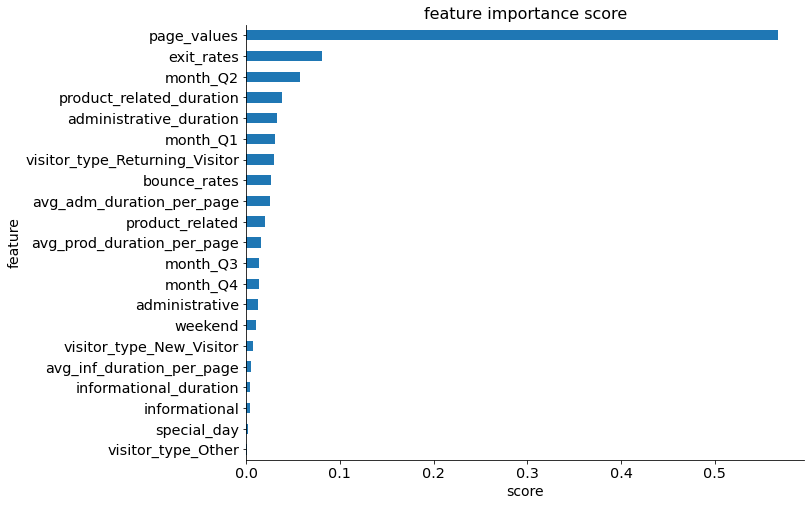

In [ ]:
def show_feature_importance(model, features):
    feat_importances = pd.Series(model.feature_importances_, index=features)
    ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10, 8))
    ax.invert_yaxis()

    plt.xlabel('score', fontsize=14)
    plt.ylabel('feature', fontsize=14)
    plt.title('feature importance score', fontsize=16)
    
X_train, X_test, y_train, y_test = preprocessed_data(full_train, test, numerical, categorical, is_linear=False)
clf = classifier()['RandomForestClassifier']
model = imblearn_pipeline(
    SMOTE(sampling_strategy='all', random_state=0), 
    clf
)
model.fit(X_train, y_train)
show_feature_importance(model[-1], X_test.columns)

6 feature dengan importance score tertinggi yaitu 
* page_values, 
* exit_rates, 
* month_Q2
* product_related_duration
* administrative_duration
* month_Q1

page_values sangat berpengaruh ke model dan nilainya sangat tinggi (> 0.5) jika dibandingkan dengan feature-feature lain. Feature-feature tersebut akan digunakan untuk men-train ulang model.

### Insights dari feature importance dan rekomendasi aksi

**1. page_values**

Page values merupakan nilai rata-rata untuk halaman yang dikunjungi pengguna sebelum menyelesaikan konversi atau transaksi eCommerce (ref). Berdasarkan feature importance, dapat dilihat bahwa page values memiliki pengaruh yang signifikan terhadap konversi. Sesi dengan page values yang tinggi cenderung menghasilkan revenue, sehingga untuk menghasilkan peningkatan pada purchase/conversion rate, kita juga perlu meningkatkan page values. Salah satu caranya adalah dengan meningkatkan jumlah trafik yang berkualitas. Lakukan pengecekan: halaman mana yang memiliki traffic yang tinggi, tetapi page values nya rendah, lalu optimalkan konten dan interface dari halaman tersebut, sehingga memperbesar kemungkinan customer akan melakukan pembelian.

**2. month_Q2**

Dalam strategi marketing, pemilihan waktu yang tepat untuk memberikan promo atau voucher diskon juga penting. Cek event-event tertentu dari suatu bulan yang memungkinkan peningkatan jumlah user yang belanja. Dari dataset dengan asumsi ecommerce ini aktivitasnya berkegiatan di US, bulan pada Q2 yang memiliki conversion terbanyak adalah May (Mother’s day) - source. Dengan memprediksi mana customer yang akan membeli dan mana yang tidak, kita bisa melakukan aksi berupa pemberian voucher diskon khusus event tertentu kepada customer yang diprediksi tidak membeli, sehingga jadinya membeli. Untuk lebih meminimalisir cost bisa juga memberi voucher untuk pembelian produk yang kemungkinan banyak dibutuhkan pada event tersebut atau pada bulan tersebut (misal: produk coklat saat valentine, kotak kado di libur natal, etc)

**3. exit_rates**

Sesi yang menghasilkan pendapatan cenderung memiliki exit rate yang lebih rendah dibandingkan yang tidak menghasilkan revenue. Sehingga untuk meningkatkan conversion rate/purchase rate, diperlukan aksi yang dapat membantu mengoptimalisasi exit rate. Lakukan pengecekan halaman mana dari ecommerce yang memiliki exit rates paling tinggi. Lalu lakukan optimalisasi. Jika ternyata halaman yang memiliki exit rates tinggi adalah halaman produk, atau halaman check out, lakukan lagi pengecekan kenapa user tidak melanjutkan proses conversi. Apakah karena harga, atau waktu tertentu yang tidak tepat untuk membeli suatu barang.

**4. product_related_duration**

Bila dilihat dari seluruh transaksi yang menghasilkan revenue, sebagian besar adalah berasal dari visit ke product page. Durasi kunjungan ke product page cukup berpengaruh terhadap konversi. Namun, 90% total kunjungan product page dibandingkan dengan 15% sesi yang menghasilkan conversion, terbilang rendah. Sehingga sama dengan rekomendasi pada exit rates, kita perlu melakukan pengecekan terhadap product related page dari segi interface, kemudahan akses, kejelasan informasi dan demonstrasi produk, dll. Apakah high product page visit tapi low conversion disebabkan oleh hal-hal tersebut.

**5. administrative_duration**

Dari sisi domain knowledge, durasi kunjungan ke administrative page seharusnya tidak berperan dalam peningkatan jumlah konversi. Namun dari feature importance, administrative duration termasuk salah satu feature yang memiliki pengaruh yang cukup tinggi ke model, dimana dari sesi yang menghasilkan transaksi, sebagian besar memiliki kunjungan ke administrative page. Perlu di cek apakah user yang melakukan konversi dan memiliki kunjungan ke administrative page merupakan proses UAT atau bukan. Asumsi: administrative page adalah admin user page (dashboard).








### B. Feature Selection

In [ ]:
X_train, X_test, y_train, y_test = preprocessed_data(full_train, test, numerical, categorical, is_linear=False)
selected_features = [
    "page_values",
    "exit_rates",
    "month_Q2",
    "product_related_duration",
    "administrative_duration",
]
clf = classifier()['RandomForestClassifier']
model = imblearn_pipeline(
    SMOTE(sampling_strategy='all', random_state=0), 
    clf
)

print("all features")
model.fit(X_train, y_train)
display(model_evaluation(model, X_test, y_test, dataset='Test'))

print(f"\nuse {len(selected_features)} features:{selected_features}")
model.fit(X_train[selected_features], y_train)
display(model_evaluation(model, X_test[selected_features], y_test, dataset='Test'))

all features


{'model': 'randomforestclassifier',
 'Accuracy (Test set)': 0.89,
 'Precision (Test set)': 0.618,
 'Recall (Test set)': 0.78,
 'F1 (Test set)': 0.69,
 'F0.5 (Test set)': 0.645,
 'ROC AUC (Test set)': 0.922}


use 5 features:['page_values', 'exit_rates', 'month_Q2', 'product_related_duration', 'administrative_duration']


{'model': 'randomforestclassifier',
 'Accuracy (Test set)': 0.884,
 'Precision (Test set)': 0.602,
 'Recall (Test set)': 0.772,
 'F1 (Test set)': 0.677,
 'F0.5 (Test set)': 0.63,
 'ROC AUC (Test set)': 0.911}

In [ ]:
X_train, X_test, y_train, y_test = preprocessed_data(full_train, test, numerical, categorical, is_linear=False)
selected_features = [
    "page_values",
    "exit_rates",
    "month_Q2",
    "product_related_duration",
    "administrative_duration",
    "month_Q1",
    "visitor_type_Returning_Visitor",
    "bounce_rates",
    "avg_adm_duration_per_page"
]
clf = classifier()['RandomForestClassifier']
model = imblearn_pipeline(
    SMOTE(sampling_strategy='all', random_state=0), 
    clf
)

print("all features")
model.fit(X_train, y_train)
display(model_evaluation(model, X_test, y_test, dataset='Test'))

print(f"\nuse {len(selected_features)} features:{selected_features}")
model.fit(X_train[selected_features], y_train)
display(model_evaluation(model, X_test[selected_features], y_test, dataset='Test'))

all features


{'model': 'randomforestclassifier',
 'Accuracy (Test set)': 0.89,
 'Precision (Test set)': 0.618,
 'Recall (Test set)': 0.78,
 'F1 (Test set)': 0.69,
 'F0.5 (Test set)': 0.645,
 'ROC AUC (Test set)': 0.922}


use 9 features:['page_values', 'exit_rates', 'month_Q2', 'product_related_duration', 'administrative_duration', 'month_Q1', 'visitor_type_Returning_Visitor', 'bounce_rates', 'avg_adm_duration_per_page']


{'model': 'randomforestclassifier',
 'Accuracy (Test set)': 0.888,
 'Precision (Test set)': 0.613,
 'Recall (Test set)': 0.772,
 'F1 (Test set)': 0.684,
 'F0.5 (Test set)': 0.64,
 'ROC AUC (Test set)': 0.92}

**Pengamatan**
* Apabila menggunakan 5 atau 9 features dengan importance paling tinggi, nilai precision dan ROC AUC lebih rendah dibandingkan dengan memakai semua features

## 3. Git

**Repository for Final Project**

https://github.com/irfan-fadhlurrahman/online-shoppers-purchasing-intention